In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
#ip <- installed.packages() 
#pkgs.to.remove <- ip[!(ip[,"Priority"] %in% c("base", "recommended")), 1]
#sapply(pkgs.to.remove, remove.packages)

NULL


In [3]:
%%R
#source("http://bioconductor.org/biocLite.R")
#biocLite("phyloseq")

NULL


In [2]:
%%R
library("phyloseq")
library(ggplot2)

In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [5]:
%%R
ps.b = subset_taxa(physeq,Kingdom=="Bacteria")
ps.b = subset_samples(ps.b,sample_sums(physeq)>3000)

In [4]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>1500)

In [16]:
%%R
physeq.2.5.noSmall<-subset_samples(physeq.noSmall, Month==2.5)

In [22]:
%%R
physeq.2.5<-subset_samples(physeq, Month==2.5)

In [5]:
%%R
ps <- physeq.noSmall

In [6]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [7]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", weighted=TRUE, k=3, trymax=40)
# Consider trymax= and k=3

Run 0 stress 0.08815468 
Run 1 stress 0.09737201 
Run 2 stress 0.08645625 
... New best solution
... procrustes: rmse 0.03817837  max resid 0.2250864 
Run 3 stress 0.08645163 
... New best solution
... procrustes: rmse 0.004508968  max resid 0.0192207 
Run 4 stress 0.08800468 
Run 5 stress 0.08644923 
... New best solution
... procrustes: rmse 0.004092418  max resid 0.01756378 
Run 6 stress 0.09896753 
Run 7 stress 0.08644413 
... New best solution
... procrustes: rmse 0.003271458  max resid 0.01351662 
Run 8 stress 0.08799333 
Run 9 stress 0.08644218 
... New best solution
... procrustes: rmse 0.002899442  max resid 0.0137347 
Run 10 stress 0.08644577 
... procrustes: rmse 0.003219837  max resid 0.01420131 
Run 11 stress 0.08644362 
... procrustes: rmse 0.002952725  max resid 0.01338949 
Run 12 stress 0.08988657 
Run 13 stress 0.08800594 
Run 14 stress 0.09822232 
Run 15 stress 0.08680399 
... procrustes: rmse 0.009778885  max resid 0.06218728 
Run 16 stress 0.1010235 
Run 17 stress 0

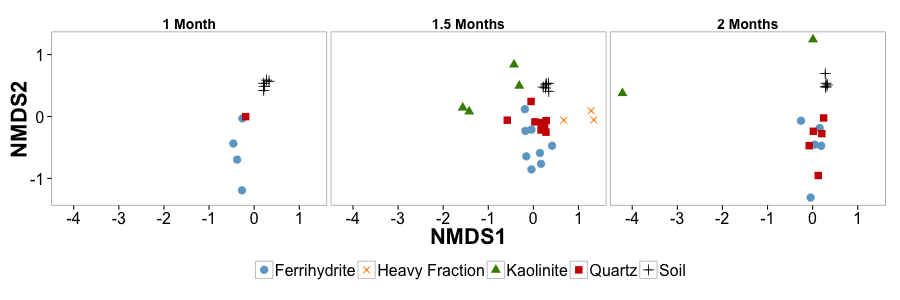

In [10]:
%%R -h 300 -w 900
D <- ord.full
# Sets the relevant ordination

sample_data(ps_snorm)$Cosm=as.factor(sample_data(ps_snorm)$Cosm)
sample_data(ps_snorm)$Month=as.factor(sample_data(ps_snorm)$Month)
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"1.5 Months","2 Months"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = plot_ordination(ps_snorm, D, color = "Trtmt", shape = "Trtmt", axes=c(1,2))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","darkorange","chartreuse4","red3","black","gold1"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))
p = p + scale_shape_manual(values=c(19,4,17,15,3))

p = p + scale_x_continuous(breaks=c(-4,-3,-2,-1,0,1))
p = p + scale_y_continuous(breaks=c(-1,0,1))

p = p + theme_bw() +
  theme(
      legend.position = "bottom",
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=22, face="bold"),
        axis.text = element_text(size=16),
        legend.text = element_text(size=16),
        legend.title = element_text(size = 22),
        strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [87]:
%%R
ggsave(filename="NMDS-16S-3month.jpg", plot=p ,width=8.5, height=4)

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
See Soil_Effect notebook. There is not a significant difference detected.

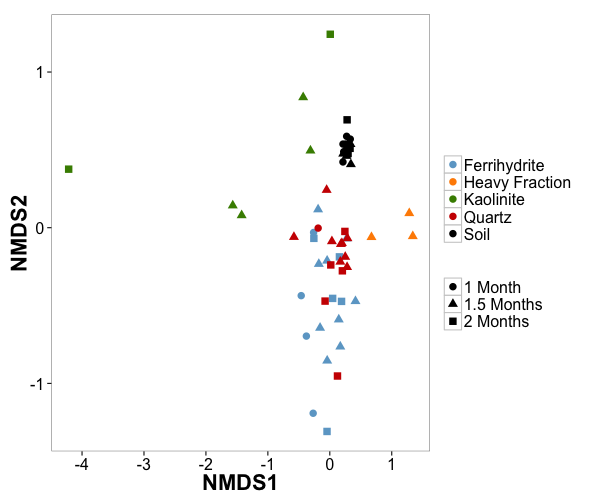

In [14]:
%%R -h 500 -w 600
D <- ord.full
# Sets the relevant ordination

sample_data(ps_snorm)$Cosm=as.factor(sample_data(ps_snorm)$Cosm)
sample_data(ps_snorm)$Month=as.factor(sample_data(ps_snorm)$Month)
sample_data(ps_snorm)$MonthName=ifelse(sample_data(ps_snorm)$Month==2.0,"1 Month", ifelse(sample_data(ps_snorm)$Month==2.5,"1.5 Months","2 Months"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = plot_ordination(ps_snorm, D, color = "Trtmt", shape = "MonthName", axes=c(1,2))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) + scale_colour_manual(values=c("skyblue3","darkorange","chartreuse4","red3","black","gold1"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))
#p = p + scale_shape_manual(values=c(19,4,17,15,3))

p = p + scale_x_continuous(breaks=c(-4,-3,-2,-1,0,1))
p = p + scale_y_continuous(breaks=c(-1,0,1))

p = p + theme_bw() +
  theme(
      legend.position = "right",
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=22, face="bold"),
        axis.text = element_text(size=16),
        legend.text = element_text(size=16),
        legend.title = element_text(size = 22),
        strip.background = element_rect(colour="white", fill="white"))

#p = p + facet_grid(~MonthName)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

In [15]:
%%R
ggsave(filename="NMDS-16S-AllMonths.jpg", plot=p ,width=7, height=5)

Error in { : task 367 failed - "Interrupted"
In addition: Warning message:
In UniFrac(physeq, ...) :
  Randomly assigning root as -- 58_179884 -- in the phylogenetic tree in the data you provided.
Square root transformation
Wisconsin double standardization
Run 0 stress 0.09380201 
Run 1 stress 0.09445325 
Run 2 stress 0.09523874 
Run 3 stress 0.09418401 
... procrustes: rmse 0.01205185  max resid 0.06188465 
Run 4 stress 0.09380017 
... New best solution
... procrustes: rmse 0.0002785023  max resid 0.001598697 
*** Solution reached


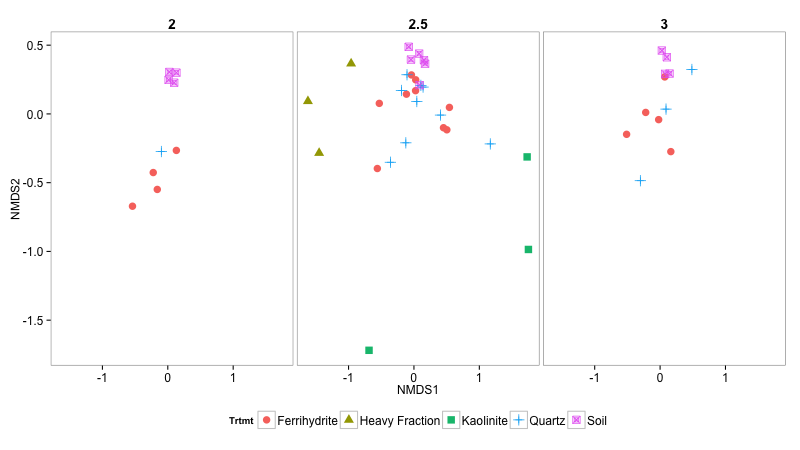

In [19]:
%%R -h 450 -w 800
# Computing the Bray distance matrix and NMDS in parallel

#ps = prune_samples(sample_data(ps_snorm)$Trtmt=="Soil"|sample_data(ps_snorm)$Trtmt=="Ferrihydrite", ps_snorm)

ord.full = ordinate(ps, method = "NMDS", distance = "bray", weighted=TRUE, k=3, trymax=40)
# Consider trymax= and k=3

D <- ord.full
# Sets the relevant ordination

sample_data(ps)$Cosm=as.factor(sample_data(ps)$Cosm)
sample_data(ps)$Month=as.factor(sample_data(ps)$Month)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = plot_ordination(ps, D, color = "Trtmt", shape = "Trtmt", axes=c(1,2))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) 

p = p + guides(color = element_blank(), shape = element_blank())

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
      legend.position = "bottom"
    ,plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p